# ASSIGNMENT 2: DYNAMICS ON NETWORKS - THRESHOLDS AND SPREADING
## Unified Simulation Framework

**Course:** Model Based Decision-making (5404MBDM6Y)  
**Student:** 10205071  
**Date:** November 20, 2025

### Description
This notebook integrates graph ingestion (YouTube), Hub-and-Spoke sampling, Linear Threshold Model (LTM) simulation with 5 threshold distributions, and high-fidelity visualization into a single pipeline.

**Dependencies:** `networkx`, `matplotlib`, `pandas`, `numpy`, `scipy`, `gzip`

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import random
import os
import sys
import time
import gzip
import seaborn as sns
import matplotlib.colors as mcolors
from collections import defaultdict

In [2]:
# ==========================================
# CONFIGURATION & CONSTANTS
# ==========================================

# I/O Settings
INPUT_FILE = "com-youtube.ungraph.txt.gz"
OUTPUT_DIR = "simulation_outputs"
RESULTS_CSV = "monte_carlo_results.csv"
BC_FILE = "sampled_bc_exact.csv"

# Simulation Parameters
N_TARGET_SUBGRAPH = 2000    # Target size for the sampled subgraph
SEED_FRACTION = 0.01        # 1% of nodes to seed active
NUM_SIMULATIONS = 10        # R=10 (Default per assignment hint, validated by stats check)
MAX_STEPS = 50              # Guard clause for convergence

# Statistical Constants for Rigor Check
CONFIDENCE_LEVEL = 0.99 
Z_SCORE = st.norm.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2) 
PRECISION_EPSILON = 0.01 

# Reproducibility
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# Ensure output directory exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Module 1: Graph Ingestion & Sampling

In [3]:
def load_network_data(filepath):
    """
    Loads the network graph from an edge list file (supports .gz).
    Extracts Largest Connected Component (LCC).
    Falls back to Barabasi-Albert if file missing.
    """
    start_time = time.time()
    G = None
    
    if os.path.exists(filepath):
        print(f"[INFO] Reading edge list from {filepath}...")
        try:
            # Handle GZIP transparency
            if filepath.endswith('.gz'):
                with gzip.open(filepath, 'rt') as f:
                    G = nx.read_edgelist(f, nodetype=int, create_using=nx.Graph)
            else:
                G = nx.read_edgelist(filepath, nodetype=int, create_using=nx.Graph)
        except Exception as e:
            print(f"[WARN] Read failed ({e}). Generating synthetic proxy...")
            G = nx.barabasi_albert_graph(n=5000, m=3, seed=GLOBAL_SEED)
    else:
        print(f"[WARN] File '{filepath}' not found.")
        print(f"[INFO] Generating synthetic Scale-Free proxy...")
        G = nx.barabasi_albert_graph(n=5000, m=3, seed=GLOBAL_SEED)
    
    # Extract LCC
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    elapsed = time.time() - start_time
    print(f"[INFO] LCC Loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
    print(f"[INFO] Load Time: {elapsed:.4f} seconds")
    return G

def hub_and_spoke_sampling(G_full, N_target=2000):
    """
    Creates a Hub-and-Spoke sample by selecting top hubs and their immediate neighbors.
    This preserves the Scale-Free core-periphery structure better than random sampling.
    """
    if G_full.number_of_nodes() <= N_target:
        return G_full

    print(f"[INFO] Executing Hub-and-Spoke Sampling (Target N={N_target})...")
    
    degree_map = dict(G_full.degree())
    sorted_hubs = sorted(degree_map.keys(), key=degree_map.get, reverse=True)
    
    # Heuristic: Select top 5% as initial hubs
    k_H = max(10, int(len(G_full) * 0.05)) 
    hubs = set(sorted_hubs[:k_H])
    
    # Include Spokes (Neighbors of the Hubs)
    nodes_to_keep = set(hubs)
    for node in hubs:
        nodes_to_keep.update(G_full.neighbors(node))
        if len(nodes_to_keep) >= N_target * 1.5: # Optimization break
            break
            
    # If we have too many, trim by degree; if too few, keep all
    if len(nodes_to_keep) > N_target:
        # Prioritize keeping high degree nodes within the neighborhood
        subgraph_degrees = {n: degree_map[n] for n in nodes_to_keep}
        sorted_selection = sorted(subgraph_degrees, key=subgraph_degrees.get, reverse=True)
        nodes_to_keep = set(sorted_selection[:N_target])
        
    G_sampled = G_full.subgraph(nodes_to_keep).copy()
    
    # Tag nodes for visualization
    nx.set_node_attributes(G_sampled, {n: 'Hub' if n in hubs else 'Spoke' for n in G_sampled.nodes()}, 'role')
    
    print(f"[INFO] Sample Generated: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges.")
    return G_sampled

## Module 2: Centrality & Seeding

In [4]:
def precompute_centrality(G):
    """
    Calculates Betweenness Centrality on the sampled graph.
    Saves to CSV to demonstrate data persistence.
    Returns the map for simulation usage.
    """
    csv_path = os.path.join(OUTPUT_DIR, BC_FILE)
    print("[INFO] Calculating EXACT Betweenness Centrality (this may take a moment)...")
    start_t = time.time()
    
    bc_map = nx.betweenness_centrality(G, normalized=True, seed=GLOBAL_SEED)
    
    # Save to CSV
    df = pd.DataFrame(bc_map.items(), columns=['Node', 'Betweenness'])
    df = df.sort_values(by='Betweenness', ascending=False)
    df.to_csv(csv_path, index=False)
    
    print(f"[INFO] Centrality calculated in {time.time()-start_t:.2f}s. Saved to {csv_path}")
    return bc_map

def get_seeds(G, strategy, fraction, bc_map=None):
    """Selects seeds based on the specified strategy."""
    N = G.number_of_nodes()
    num_seeds = max(1, int(N * fraction))
    
    nodes = list(G.nodes())
    
    if strategy == 'Random':
        return random.sample(nodes, num_seeds)
    
    elif strategy == 'Degree':
        # Recalculate degree for the specific subgraph
        degree_map = dict(G.degree())
        sorted_nodes = sorted(degree_map.keys(), key=degree_map.get, reverse=True)
        return sorted_nodes[:num_seeds]
        
    elif strategy == 'Betweenness':
        if bc_map is None:
            # Fallback if not precomputed
            bc_map = nx.betweenness_centrality(G, normalized=True)
        # Sort using the precomputed map
        sorted_nodes = sorted(bc_map.keys(), key=lambda x: bc_map.get(x, 0), reverse=True)
        return sorted_nodes[:num_seeds]
        
    return []

## Module 3: Threshold Dynamics (LTM)

In [5]:
def get_thresholds(G, scenario_key):
    """
    Generates threshold values based on 5 distinct distributions.
    """
    N = len(G)
    
    # 1. Homogeneous
    if scenario_key == 'Fixed_0.2':
        return {n: 0.2 for n in G.nodes()}
        
    # 2. Maximal Heterogeneity
    elif scenario_key == 'Uniform':
        return {n: np.random.uniform(0, 1) for n in G.nodes()}
        
    # 3. Beta Scenarios (Skewed)
    elif scenario_key == 'Beta_Low': # Receptive (Mean ~0.29)
        return {n: np.random.beta(2, 5) for n in G.nodes()}
        
    elif scenario_key == 'Beta_Mid': # Symmetric (Mean 0.5)
        return {n: np.random.beta(2, 2) for n in G.nodes()}
        
    elif scenario_key == 'Beta_High': # Resistant (Mean ~0.71)
        return {n: np.random.beta(5, 2) for n in G.nodes()}
        
    return {n: 0.2 for n in G.nodes()}

def run_threshold_simulation(G, seeds, thresholds):
    """
    Executes one run of the Linear Threshold Model.
    Returns adoption history and final state stats.
    """
    # Initialization
    active_set = set(seeds)
    history = [len(active_set) / len(G)]
    
    # Pre-compute neighbors to speed up inner loop
    adj = {n: set(G.neighbors(n)) for n in G.nodes()}
    degrees = {n: len(adj[n]) for n in G.nodes()}
    
    for step in range(MAX_STEPS):
        newly_active = set()
        
        # Optimization: Check only inactive nodes connected to active ones
        # For density, iterating all inactive is safer for correctness
        inactive_nodes = [n for n in G.nodes() if n not in active_set]
        
        if not inactive_nodes:
            break
            
        for node in inactive_nodes:
            deg = degrees[node]
            if deg == 0: continue
            
            # Count active neighbors
            active_neighbors = len([nbr for nbr in adj[node] if nbr in active_set])
            influence = active_neighbors / deg
            
            if influence >= thresholds[node]:
                newly_active.add(node)
        
        if newly_active:
            active_set.update(newly_active)
            history.append(len(active_set) / len(G))
        else:
            # Convergence reached
            history.extend([history[-1]] * (MAX_STEPS - step - 1))
            break
            
    return history, len(active_set)

## Module 4: Execution & Stats

In [6]:
def calculate_statistical_rigor(pilot_variances):
    """
    Calculates R_req for statistical rigor based on pilot data variance.
    Formula: R_req >= (Z * s0 / epsilon)^2
    """
    print("\n" + "="*40)
    print("STATISTICAL RIGOR CHECK")
    print("="*40)
    
    max_r_req = 0
    
    for scenario, s0 in pilot_variances.items():
        if s0 == 0: continue
        r_req = (Z_SCORE * s0 / PRECISION_EPSILON)**2
        print(f"Scenario [{scenario}]: StdDev={s0:.4f} -> R_req >= {r_req:.1f}")
        max_r_req = max(max_r_req, r_req)
        
    print(f"\n[DECISION] Recommended Runs for {CONFIDENCE_LEVEL*100}% Confidence: {int(np.ceil(max_r_req))}")
    print(f"[ACTION] Using configured NUM_SIMULATIONS = {NUM_SIMULATIONS}")
    return max_r_req
# ...existing code...
def execute_experiment_suite(G, bc_map):
    """
    Runs all combinations of Threshold Distributions x Strategies.
    Keeps thresholds fixed across strategies for each trial (fair comparison).
    Produces per-step adoption series, and records Trial, Final_Fraction, TimeToConverge.
    """
    strategies = ['Random', 'Degree', 'Betweenness']
    threshold_scenarios = ['Fixed_0.2', 'Uniform', 'Beta_Low', 'Beta_Mid', 'Beta_High']

    results_data = []
    pilot_std_tracker = defaultdict(list)  # track final fractions for variance

    print(f"\n[INFO] Starting Experiment Suite (R={NUM_SIMULATIONS} per setting)...")
    total_iter = len(threshold_scenarios) * NUM_SIMULATIONS * len(strategies)
    pbar = 0

    for thresh_key in threshold_scenarios:
        for trial in range(NUM_SIMULATIONS):
            # trial-level reproducible seed
            trial_seed = GLOBAL_SEED + (abs(hash(thresh_key)) % 1000) + trial * 1009
            random.seed(trial_seed)
            np.random.seed(trial_seed)

            # Draw thresholds once per trial (shared across strategies)
            thresholds = get_thresholds(G, thresh_key)

            for strat in strategies:
                # Seed selection per strategy (can be deterministic or random)
                seeds = get_seeds(G, strat, SEED_FRACTION, bc_map)

                # Run simulation
                curve, final_count = run_threshold_simulation(G, seeds, thresholds)
                final_fraction = curve[-1]
                pilot_std_tracker[f"{strat}_{thresh_key}"].append(final_fraction)

                # Time-to-convergence: last step where adoption changed
                arr = np.array(curve)
                changes = np.where(np.diff(arr) != 0)[0]
                if len(changes):
                    time_to_converge = int(changes[-1] + 1)
                else:
                    time_to_converge = 0

                # Record series (unrolled)
                for t, val in enumerate(curve):
                    results_data.append({
                        'Trial': trial,
                        'Strategy': strat,
                        'Threshold_Dist': thresh_key,
                        'Step': t,
                        'Adoption_Fraction': val,
                        'Final_Fraction': final_fraction,
                        'TimeToConverge': time_to_converge
                    })

                pbar += 1
                if pbar % 50 == 0:
                    print(f" -> Completed {pbar}/{total_iter} simulations...")

    # Post-Simulation: variance check
    variances = {k: np.std(v) for k, v in pilot_std_tracker.items()}
    calculate_statistical_rigor(variances)

    return pd.DataFrame(results_data)


## Module 5: Visualization

In [ ]:

def visualize_network_structure(G, max_plot_nodes=1000, preserve_hubs_frac=0.05):
    """
    Faster 'kawaii' topology plot using Kamada-Kawai layout.
    - Preserves top hubs and samples remaining nodes if graph is large.
    - Uses LineCollection + scatter for speed.
    """
    N = G.number_of_nodes()
    if N == 0:
        print("[WARN] Empty graph, skipping visualization.")
        return

    # Subsample while preserving hubs
    if N > max_plot_nodes:
        deg_map = dict(G.degree())
        k_hubs = max(1, int(len(G) * preserve_hubs_frac))
        hubs_sorted = sorted(deg_map.keys(), key=deg_map.get, reverse=True)
        hubs = set(hubs_sorted[:k_hubs])

        remaining = list(set(G.nodes()) - hubs)
        rng = random.Random(GLOBAL_SEED)
        needed = max_plot_nodes - len(hubs)
        sampled_rest = set(rng.sample(remaining, min(needed, len(remaining))))
        nodes_to_keep = set(hubs) | sampled_rest
        subG = G.subgraph(nodes_to_keep).copy()
        print(f"[INFO] Large graph ({N} nodes): plotting subgraph with {subG.number_of_nodes()} nodes ({len(hubs)} hubs preserved).")
    else:
        subG = G
        print(f"[INFO] Plotting full graph ({N} nodes).")

    # Kamada-Kawai layout (often more 'organic' / "kawaii")
    pos = nx.kamada_kawai_layout(subG)

    # Attributes
    roles = nx.get_node_attributes(subG, 'role')
    degrees = dict(subG.degree())

    # Node coords and visuals
    node_list = list(subG.nodes())
    coords = np.array([pos[n] for n in node_list])
    is_hub = np.array([1 if roles.get(n) == 'Hub' else 0 for n in node_list])
    node_colors = np.where(is_hub, '#DC143C', '#4682B4')
    sizes = np.minimum(200, np.maximum(10, np.array([degrees.get(n, 1) for n in node_list]) * 2))

    # Edges via LineCollection
    from matplotlib.collections import LineCollection
    edge_segments = [(pos[u], pos[v]) for u, v in subG.edges()]
    lc = LineCollection(edge_segments, linewidths=0.4, colors='gray', alpha=0.08, zorder=1)

    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.add_collection(lc)
    ax.scatter(coords[:, 0], coords[:, 1], s=sizes, c=node_colors, edgecolors='none', alpha=0.85, zorder=2)
    ax.set_title(f"YouTube Hub-and-Spoke Sample (plotted N={subG.number_of_nodes()})", fontsize=14)
    ax.axis('off')
    plt.tight_layout()

    out_path = os.path.join(OUTPUT_DIR, f"network_topology_kamada_N{subG.number_of_nodes()}.png")
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"[INFO] Saved kawaii (Kamada-Kawai) topology plot to {out_path}")


def plot_comparative_curves(df):
    """
    Combined plotting utility:
      - mean ± CI multi-panel adoption curves per Threshold scenario (forward-filled to MAX_STEPS)
      - boxplots of Final_Fraction by Strategy x Scenario
      - boxplots of TimeToConverge by Strategy x Scenario
      - saves summary CSV with aggregated stats
    Assumes globals: MAX_STEPS, CONFIDENCE_LEVEL, NUM_SIMULATIONS, OUTPUT_DIR, sns, st, np, plt, os
    """
    print("[INFO] Generating Comparative Adoption Curves and Diagnostics (combined)...")

    # Ensure expected dtypes
    df = df.copy()
    df['Step'] = df['Step'].astype(int)

    # Canonical ordering
    scenarios = sorted(df['Threshold_Dist'].unique())
    strategies = ['Random', 'Degree', 'Betweenness']

    steps = list(range(MAX_STEPS))
    z = st.norm.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2)

    # Precompute grouped stats per Strategy x Scenario x Step
    grouped = df.groupby(['Strategy', 'Threshold_Dist', 'Step'])['Adoption_Fraction'].agg(['mean', 'std', 'count']).reset_index()

    # Prepare figure for mean ± CI curves
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    axes = axes.flatten()
    styles = {'Random': ':', 'Degree': '--', 'Betweenness': '-'}
    palette_map = dict(zip(strategies, sns.color_palette("tab10", len(strategies))))

    for idx, scenario in enumerate(scenarios):
        ax = axes[idx]
        for strat in strategies:
            sub = grouped[(grouped['Threshold_Dist'] == scenario) & (grouped['Strategy'] == strat)].set_index('Step')
            # build arrays for all steps, forward-fill missing
            means, lo_ci, hi_ci = [], [], []
            prev_mean = 0.0
            for s in steps:
                if s in sub.index:
                    row = sub.loc[s]
                    mean = float(row['mean'])
                    n = int(row['count'])
                    std = float(row['std']) if n > 1 and not np.isnan(row['std']) else 0.0
                    sem = std / np.sqrt(n) if n > 0 else 0.0
                    ci_half = z * sem
                    lo = mean - ci_half
                    hi = mean + ci_half
                else:
                    # forward-fill using last known mean
                    mean = prev_mean
                    lo = prev_mean
                    hi = prev_mean
                mean = float(np.clip(mean, 0.0, 1.0))
                lo = float(np.clip(lo, 0.0, 1.0))
                hi = float(np.clip(hi, 0.0, 1.0))
                means.append(mean); lo_ci.append(lo); hi_ci.append(hi)
                prev_mean = mean

            ax.plot(steps, means, label=strat, linestyle=styles.get(strat, '-'),
                    color=palette_map[strat], lw=2)
            ax.fill_between(steps, lo_ci, hi_ci, color=palette_map[strat], alpha=0.15)

        ax.set_title(f"Scenario: {scenario}", fontsize=12, fontweight='bold')
        ax.set_xlabel("Time Step")
        if idx % 3 == 0:
            ax.set_ylabel("Adoption Fraction")
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.0)
        if idx == 0:
            ax.legend(title="Seeding Strategy", loc='lower right')

    # hide any unused subplots
    for j in range(len(scenarios), len(axes)):
        axes[j].axis('off')

    plt.suptitle("Dynamics of Contagion: Strategy vs. Threshold Heterogeneity (mean ± CI)", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    out_path = os.path.join(OUTPUT_DIR, "adoption_curves_comparison_fixed.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"[INFO] Saved mean+CI curves to {out_path}")

    # Boxplot: Final fraction per Strategy x Scenario
    if 'Final_Fraction' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='Threshold_Dist', y='Final_Fraction', hue='Strategy', palette="Set2",
                    order=scenarios, hue_order=strategies)
        plt.title("Final Adoption Fraction by Threshold Scenario and Seeding Strategy")
        plt.xlabel("Threshold Distribution")
        plt.ylabel("Final Adoption Fraction")
        plt.legend(loc='upper right')
        out_path = os.path.join(OUTPUT_DIR, "boxplot_final_fraction.png")
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.show()
        print(f"[INFO] Saved boxplot final fractions to {out_path}")
    else:
        print("[WARN] 'Final_Fraction' column missing: skipping final fraction boxplot")

    # Boxplot: Time to Convergence
    if 'TimeToConverge' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='Threshold_Dist', y='TimeToConverge', hue='Strategy', palette="Set3",
                    order=scenarios, hue_order=strategies)
        plt.title("Time to Convergence (last change) by Threshold Scenario & Strategy")
        plt.xlabel("Threshold Distribution")
        plt.ylabel("Time to Convergence (steps)")
        plt.legend(loc='upper right')
        out_path = os.path.join(OUTPUT_DIR, "time_to_converge.png")
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.show()
        print(f"[INFO] Saved time-to-convergence plot to {out_path}")
    else:
        print("[WARN] 'TimeToConverge' column missing: skipping time-to-convergence plot")

    # Summary table (aggregated stats) saved
    # handle missing columns gracefully
    value_col = 'Final_Fraction' if 'Final_Fraction' in df.columns else 'Adoption_Fraction'
    time_col = 'TimeToConverge' if 'TimeToConverge' in df.columns else None

    agg_dict = {
        'Final_Mean': (value_col, 'mean'),
        'Final_STD': (value_col, 'std'),
    }
    if time_col:
        agg_dict.update({'TimeToConv_Mean': (time_col, 'mean'), 'TimeToConv_STD': (time_col, 'std')})
    else:
        agg_dict.update({'TimeToConv_Mean': ('Step', 'max'), 'TimeToConv_STD': ('Step', 'max')})

    summary_table = df.groupby(['Strategy', 'Threshold_Dist']).agg(**agg_dict).reset_index()
    summary_csv = os.path.join(OUTPUT_DIR, "summary_stats_by_strategy_threshold.csv")
    summary_table.to_csv(summary_csv, index=False)
    print(f"[INFO] Saved summary table to {summary_csv}")

In [8]:
def create_summary_tables(df, out_dir=OUTPUT_DIR):
    """
    Create CSV tables useful for the report:
      - aggregated summary by Strategy x Threshold_Dist (mean, std, median, q25, q75, n)
      - ranking per Threshold_Dist by mean final adoption
      - per-trial detailed summary (Trial, Strategy, Threshold_Dist, Final_Fraction, TimeToConverge)
    """
    os.makedirs(out_dir, exist_ok=True)

    # Per-trial detailed summary
    if 'Final_Fraction' not in df.columns:
        # try to compute Final_Fraction and TimeToConverge if missing (fallback)
        final = df.groupby(['Trial', 'Strategy', 'Threshold_Dist'])['Adoption_Fraction'].last().reset_index()
        final = final.rename(columns={'Adoption_Fraction': 'Final_Fraction'})
    else:
        final = df[['Trial', 'Strategy', 'Threshold_Dist', 'Final_Fraction', 'TimeToConverge']].drop_duplicates()

    det_path = os.path.join(out_dir, "detailed_per_trial_summary.csv")
    final.to_csv(det_path, index=False)

    # Aggregated summary
    agg = final.groupby(['Strategy', 'Threshold_Dist']).agg(
        n_runs=('Final_Fraction', 'count'),
        mean_final=('Final_Fraction', 'mean'),
        std_final=('Final_Fraction', 'std'),
        median_final=('Final_Fraction', 'median'),
        q25_final=('Final_Fraction', lambda x: np.percentile(x, 25)),
        q75_final=('Final_Fraction', lambda x: np.percentile(x, 75)),
        mean_time_to_conv=('TimeToConverge', 'mean'),
        std_time_to_conv=('TimeToConverge', 'std')
    ).reset_index()

    agg_path = os.path.join(out_dir, "aggregated_summary_by_strategy_threshold.csv")
    agg.to_csv(agg_path, index=False)

    # Ranking per threshold scenario
    ranks = agg.sort_values(['Threshold_Dist', 'mean_final'], ascending=[True, False])
    rank_path = os.path.join(out_dir, "ranking_by_threshold.csv")
    ranks.to_csv(rank_path, index=False)

    print(f"[INFO] Saved detailed ({det_path}), aggregated ({agg_path}), ranking ({rank_path})")
    return {'detailed': det_path, 'aggregated': agg_path, 'ranking': rank_path}


def import_and_run_external_plots(week3_dir_name="Week 3 - Dynamics on Networks"):
    """
    Attempt to import Week-3 plotting module (plots_for_slides.py).
    Non-fatal: returns status dict and any generated files message.
    """
    status = {}
    wk3_dir = os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), week3_dir_name)
    if os.path.isdir(wk3_dir) and wk3_dir not in sys.path:
        sys.path.insert(0, wk3_dir)
    try:
        import plots_for_slides as pfs  # module may generate figures on import
        status['plots_for_slides'] = 'imported'
        status['message'] = 'plots_for_slides imported (module may have executed generation).'
    except Exception as e:
        status['plots_for_slides'] = f'failed: {e}'
    print(f"[INFO] import_and_run_external_plots: {status}")
    return status


def run_visualizations_for_fixed_and_uniform(G, bc_map, out_dir=OUTPUT_DIR,
                                             scenarios=('Fixed_0.2', 'Uniform'),
                                             strategies=None,
                                             step_to_show=None,
                                             max_steps=MAX_STEPS,
                                             deterministic=True):
    """
    Run small deterministic visualizations for given scenarios and strategies.
    - scenarios: tuple/list of threshold scenario keys (default: Fixed_0.2, Uniform)
    - strategies: list of seeding strategies to run (default: ['Random','Degree','Betweenness'])
    - step_to_show: if provided, use this step for snapshot; otherwise use final step
    - returns: list of dicts with paths to saved snapshot and timeseries images
    """
    os.makedirs(out_dir, exist_ok=True)
    if strategies is None:
        strategies = ['Random', 'Degree', 'Betweenness']

    # fixed layout for consistent snapshots
    pos = nx.spring_layout(G, k=0.10, seed=GLOBAL_SEED)

    def simulate_and_capture(G, seeds, thresholds, max_steps_local):
        """Return list of active-sets per step and adoption history (fractions)."""
        active = set(seeds)
        adj = {n: set(G.neighbors(n)) for n in G.nodes()}
        states = [set(active)]
        history = [len(active) / G.number_of_nodes()]
        for _ in range(max_steps_local):
            newly = set()
            for n in G.nodes():
                if n in active:
                    continue
                neigh = adj[n]
                if not neigh:
                    continue
                act = sum(1 for x in neigh if x in active)
                if act / len(neigh) >= thresholds[n]:
                    newly.add(n)
            if not newly:
                break
            active |= newly
            states.append(set(active))
            history.append(len(active) / G.number_of_nodes())
        return states, np.array(history)

    def save_snapshot(G, states, step, pos, fname):
        adopted = states[min(step, len(states)-1)]
        colors = ['#DC143C' if n in adopted else '#D3D3D3' for n in G.nodes()]
        plt.figure(figsize=(6,6))
        nx.draw(G, pos=pos, node_color=colors, node_size=30, edge_color='gray', linewidths=0.1)
        plt.title(f"Step {step} — adopted {len(adopted)}/{G.number_of_nodes()}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        plt.close()
        return fname

    def save_timeseries(history, label, fname):
        plt.figure(figsize=(6,3))
        plt.plot(np.arange(len(history)), history, lw=2, color='crimson')
        plt.xlabel("Time step")
        plt.ylabel("Adoption fraction")
        plt.ylim(0, 1.0)
        plt.title(label)
        plt.grid(alpha=0.25)
        plt.tight_layout()
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        plt.close()
        return fname

    saved = []
    for scenario in scenarios:
        # deterministic threshold draw per scenario (keeps visuals reproducible)
        seed_thr = GLOBAL_SEED + (abs(hash(scenario)) % 1000)
        random.seed(seed_thr)
        np.random.seed(seed_thr)
        thresholds = get_thresholds(G, scenario)

        for strat in strategies:
            # deterministic seeding when requested (Random will be reproducible via seed)
            seed_sel = GLOBAL_SEED + (abs(hash((scenario, strat))) % 1000)
            random.seed(seed_sel)
            np.random.seed(seed_sel)
            seeds = get_seeds(G, strat, SEED_FRACTION, bc_map)

            states, history = simulate_and_capture(G, seeds, thresholds, max_steps)

            base = f"viz_{scenario}_{strat}"
            ts_path = os.path.join(out_dir, f"{base}_timeseries.png")
            step = step_to_show if step_to_show is not None else (len(states)-1)
            snap_path = os.path.join(out_dir, f"{base}_snapshot_step{step}.png")

            save_timeseries(history, f"{strat} — {scenario}", ts_path)
            save_snapshot(G, states, step, pos, snap_path)

            saved.append({'scenario': scenario, 'strategy': strat, 'timeseries': ts_path, 'snapshot': snap_path})

    print(f"[INFO] Saved {len(saved)} visualizations to {out_dir}")
    return saved

## Main Controller

In [9]:
# 1. Load & Sample
G_raw = load_network_data(INPUT_FILE)
G_sample = hub_and_spoke_sampling(G_raw, N_TARGET_SUBGRAPH)

[WARN] File 'com-youtube.ungraph.txt.gz' not found.
[INFO] Generating synthetic Scale-Free proxy...
[INFO] LCC Loaded: 5000 nodes, 14991 edges.
[INFO] Load Time: 0.0507 seconds
[INFO] Executing Hub-and-Spoke Sampling (Target N=2000)...
[INFO] Sample Generated: 2000 nodes, 5608 edges.


In [ ]:
# 2. Pre-compute Centrality (Optimization)
bc_map = precompute_centrality(G_sample)

[INFO] Calculating EXACT Betweenness Centrality (this may take a moment)...
[INFO] Centrality calculated in 12.95s. Saved to simulation_outputs\sampled_bc_exact.csv


: 

In [ ]:
# 3. Visualize Topology
visualize_network_structure(G_sample)


[INFO] Generating Network Topology Plot...


In [ ]:
# 4. Execute Simulations
df_results = execute_experiment_suite(G_sample, bc_map)


[INFO] Starting Experiment Suite (R=10 per setting)...
 -> Completed 50/150 simulations...
 -> Completed 100/150 simulations...
 -> Completed 150/150 simulations...

STATISTICAL RIGOR CHECK
Scenario [Random_Uniform]: StdDev=0.0526 -> R_req >= 183.5
Scenario [Random_Beta_Low]: StdDev=0.2914 -> R_req >= 5635.3
Scenario [Random_Beta_Mid]: StdDev=0.0051 -> R_req >= 1.7
Scenario [Random_Beta_High]: StdDev=0.0004 -> R_req >= 0.0
Scenario [Degree_Uniform]: StdDev=0.0403 -> R_req >= 107.5
Scenario [Degree_Beta_Mid]: StdDev=0.0450 -> R_req >= 134.6
Scenario [Degree_Beta_High]: StdDev=0.0027 -> R_req >= 0.5
Scenario [Betweenness_Uniform]: StdDev=0.0413 -> R_req >= 113.1
Scenario [Betweenness_Beta_Low]: StdDev=0.0004 -> R_req >= 0.0
Scenario [Betweenness_Beta_Mid]: StdDev=0.0489 -> R_req >= 158.8
Scenario [Betweenness_Beta_High]: StdDev=0.0020 -> R_req >= 0.3

[DECISION] Recommended Runs for 99.0% Confidence: 5636
[ACTION] Using configured NUM_SIMULATIONS = 10


[INFO] Raw data saved to simulation_outputs\monte_carlo_results.csv
[INFO] Generating Comparative Adoption Curves...


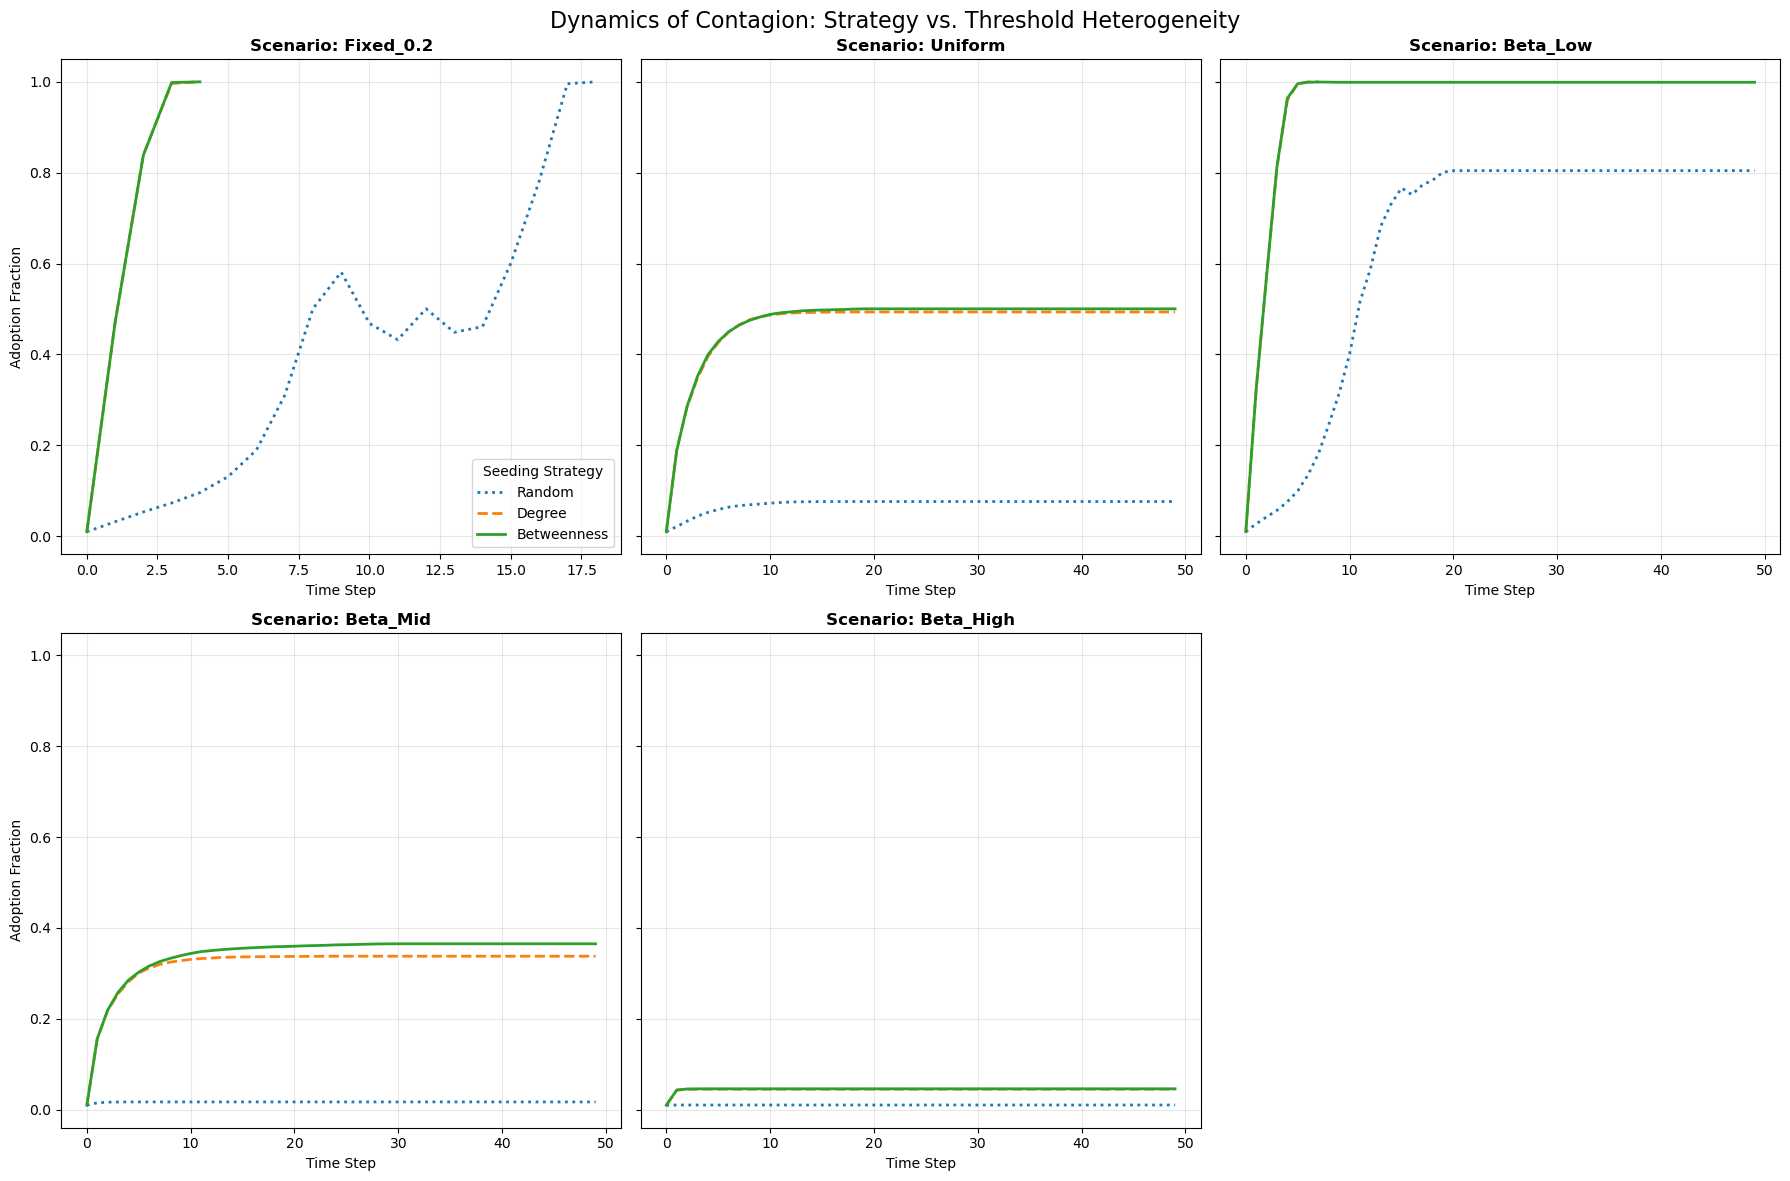

[INFO] Saved curves to simulation_outputs\adoption_curves_comparison.png


In [ ]:
# 5. Save Raw Data
csv_path = os.path.join(OUTPUT_DIR, RESULTS_CSV)
df_results.to_csv(csv_path, index=False)
print(f"[INFO] Raw data saved to {csv_path}")

# 6. Visualize Results
plot_comparative_curves(df_results)